In this notebook, we obtain $\gamma$ assuming Gaussian priors for $\alpha$ and $\beta$:

In [1]:
# Packages used:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from astropy import constants as const
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM, Planck13
from scipy import integrate as it
from multiprocessing import Pool
from functools import partial

Some parameters:

In [2]:
# Cosmology used:
cosmo = FlatLambdaCDM(H0=67.3, Om0=0.315)

# Physical constants:
c = (const.c).to(u.km/u.second)
clight = c.value

In [3]:
# data (.txt) Table I: https://arxiv.org/abs/1509.07649
# used in Schwab (https://arxiv.org/pdf/0907.4992.pdf)

In [4]:
data = np.loadtxt('../data/sample80.txt')

In [5]:
data_df = pd.DataFrame(data, columns=['z_L', 'z_S', '\sigma_0', '\sigma_0Err', '\theta_E', \
                            '\theta_ap', 'seeing', '\sigma_ap', '\sigma_apErr'])
data_df.head()

,z_L,z_S,\sigma_0,\sigma_0Err,\theta_E,\theta_ap,seeing,\sigma_ap,\sigma_apErr
0,0.517,1.364,226.0,40.0,0.68,1.0,1.8,219.0,39.0
1,0.437,0.897,277.0,51.0,0.61,1.0,1.8,281.0,51.0
2,0.530,1.332,274.0,37.0,1.14,1.0,1.8,268.0,36.0
3,0.539,1.179,207.0,35.0,0.72,1.0,1.8,204.0,34.0
4,0.642,1.297,266.0,46.0,1.37,1.0,1.8,262.0,45.0


In [6]:
n_s = len(data_df)
n_s

80

Some numbers that would be used in the Likelihood estimation:

In [7]:
z_L = data_df['z_L'].values
z_S = data_df['z_S'].values
theta_E = (data_df['\theta_E'].values * u.arcsec).to(u.rad).value
theta_ap = (data_df['\theta_ap'].values * u.arcsec).to(u.rad).value
seeing_atm = (data_df['seeing'].values * u.arcsec).to(u.rad).value
velDisp = data_df['\sigma_ap'].values
velDispErr = data_df['\sigma_apErr'].values

In [8]:
def ratio_gamma(x):
    """
    Eq. (15)
    """
    return sp.special.gamma((x - 1) / 2) / sp.special.gamma(x / 2) 

In [9]:
def vel(z_S, z_L, theta_E, seeing_atm, theta_ap, alpha, beta, gamma, delta):
    """
    Eq. (23) from Schwab.
    z_S
    z_L
    theta_E (in rad)
    seeing_atm (in rad)
    theta_ap (in rad)
    delta
    alpha
    beta
    gamma
    """
    # Angular diameter distances:
    DS = cosmo.angular_diameter_distance(z_S)
    DL = cosmo.angular_diameter_distance(z_L)
    DLS = cosmo.angular_diameter_distance_z1z2(z_L, z_S)
    
    # \chi
    chi = theta_ap/seeing_atm
    
    # \chi^tilde
    tilde_sigma = seeing_atm * np.sqrt(1 + (chi ** 2) / 4 + (chi ** 4) / 40) # Eq. (20)
    
    ksi = delta + alpha - 2
    
    term_1 = (2 / (1 + gamma)) * (clight ** 2 / 4) * (DS / DLS) * theta_E
#     term_2 = (2 / np.sqrt(np.pi)) * ((2 * (tilde_sigma ** 2)) ** (1 - alpha / 2) / (ksi - 2 * beta))
    term_2 = (2 / np.sqrt(np.pi)) * ((2 * ((tilde_sigma / theta_E) ** 2)) ** (1 - alpha / 2) / (ksi - 2 * beta))
    term_3 = (ratio_gamma(ksi) - beta * ratio_gamma(ksi + 2)) / (ratio_gamma(alpha) * ratio_gamma(delta))
    term_4 = sp.special.gamma((3 - ksi) / 2) / sp.special.gamma((3 - delta) / 2)
    
    sigma_star = term_1 * term_2 * term_3 * term_4
    
    return np.sqrt(np.abs(sigma_star))

In order to estimate $\gamma$, lets follow the tutorial in [emcee](https://emcee.readthedocs.io/en/stable/tutorials/line/):

In [10]:
def log_likelihood(theta, z_S, z_L, velDisp, velDispErr, theta_E, seeing_atm, theta_ap, delta):
    alpha, beta, gamma = theta
    model = vel(z_S, z_L, theta_E, seeing_atm, theta_ap, alpha, beta, gamma, delta)
    
    return - 0.5*np.sum((velDisp - model) ** 2 / (velDispErr ** 2) + np.log(2 * np.pi * velDispErr ** 2))

Now, finding the numerical optimal, assuming $\delta=2.4$:

In [11]:
from scipy.optimize import minimize

np.random.seed(11)
nll = lambda *args: - log_likelihood(*args)

alpha_ini = 2.0
beta_ini = 0.18
gamma_ini = 1.0

# delta:
delta = 2.4

initial = np.array([alpha_ini, beta_ini, gamma_ini]) + 0.01 * np.random.randn(3)

soln = minimize(nll, initial, args=(z_S, z_L, velDisp, velDispErr, theta_E, seeing_atm, theta_ap, delta, ))

alpha_ml, beta_ml, gamma_ml = soln.x

print("Maximum likelihood estimates:")
print("alpha = {0:.3f}".format(alpha_ml))
print("beta = {0:.3f}".format(beta_ml))
print("gamma = {0:.3f}".format(gamma_ml))

Maximum likelihood estimates:
alpha = 1.862
beta = 0.143
gamma = 0.768


Priors:

In [12]:
# Information on Schwab (5. Effect of Systematics)
alpha_0 = np.repeat(2.0, n_s)
eps_alpha_0 = np.repeat(0.08, n_s)

beta_0 = np.repeat(0.18, n_s)
eps_beta_0 = np.repeat(0.13, n_s)

In [13]:
def log_prior(theta, alpha_0, eps_alpha_0, beta_0, eps_beta_0):
    alpha, beta, gamma = theta
    n_sigma = 3
    if (alpha_0[0] - n_sigma * eps_alpha_0[0] < alpha < alpha_0[0] + n_sigma * eps_alpha_0[0]) and \
    beta_0[0] - n_sigma * eps_beta_0[0] < beta < beta_0[0] + n_sigma * eps_beta_0[0]:
        log_prior_alpha = - 0.5*np.sum((alpha - alpha_0)**2 / eps_alpha_0 ** 2 + np.log(2 * np.pi * eps_alpha_0**2))
        log_prior_beta = - 0.5*np.sum((beta - beta_0) ** 2 / eps_beta_0 ** 2 + np.log(2 * np.pi * eps_beta_0**2))
        lp = log_prior_alpha + log_prior_beta # + log_prior_gamma
        return lp   
    return - np.inf

the full log-probability function is:

In [14]:
def log_probability(theta, z_S, z_L, velDisp, velDispErr, theta_E, seeing_atm, theta_ap, delta, \
                    alpha_0, eps_alpha_0, beta_0, eps_beta_0):
    lp = log_prior(theta, alpha_0, eps_alpha_0, beta_0, eps_beta_0)
    if not np.isfinite(lp):
        return - np.inf
    return lp + log_likelihood(theta, z_S, z_L, velDisp, velDispErr, theta_E, seeing_atm, theta_ap, delta)

In [15]:
np.random.seed(11)
nll_2 = lambda *args: - log_probability(*args)

alpha_ini = 2.0
beta_ini = 0.18
gamma_ini = 1.0

# delta:
delta = 2.4

initial = np.array([alpha_ini, beta_ini, gamma_ini]) + 0.01 * np.random.randn(3)
soln_2 = minimize(nll_2, initial, args=(z_S, z_L, velDisp, velDispErr, theta_E, seeing_atm, theta_ap, delta, alpha_0, eps_alpha_0, beta_0, eps_beta_0, ))
alpha_ml2, beta_ml2, gamma_ml2 = soln_2.x

print("Maximum likelihood estimates:")
print("alpha = {0:.3f}".format(alpha_ml2))
print("beta = {0:.3f}".format(beta_ml2))
print("gamma = {0:.3f}".format(gamma_ml2))

Maximum likelihood estimates:
alpha = 1.996
beta = 0.180
gamma = 0.995


/share/storage1/TNG/Softwares/anaconda3-2020.02/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/share/storage1/TNG/Softwares/anaconda3-2020.02/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


We use now, finally,  `emcee`:

In [16]:
import emcee
 
n_dim = 3          # number of parameters in the model (r and p)
n_walkers = 64     # number of MCMC walkers
n_burn = 1000      # "burn-in" period to let chains stabilize
n_steps = 10000    # number of MCMC steps to take after burn-in

solu = np.asarray([2.0, 0.18, 1.0])
p0 = soln.x + 1e-5 * np.random.randn(n_walkers, n_dim)

sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_probability, args=(z_S, z_L, velDisp, velDispErr, theta_E, seeing_atm, theta_ap, \
                                                                         delta, alpha_0, eps_alpha_0, beta_0, eps_beta_0,));

# Run n_burn steps as a burn-in:
print('Running burn-in ...')
pos, prob, state = sampler.run_mcmc(p0, n_burn, progress=True);

# Reset the chain to remove the burn-in samples:
sampler.reset();

# Starting from the final position in the burn-in chain, sample for n_steps steps:
print('Sampling ...')
sampler.run_mcmc(pos, n_steps, rstate0=state, progress=True);

Running burn-in ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:22<00:00, 12.18it/s]


Sampling ...


100%|██████████████████████████████████████████████████████████████████████████████████| 10000/10000 [13:55<00:00, 11.98it/s]


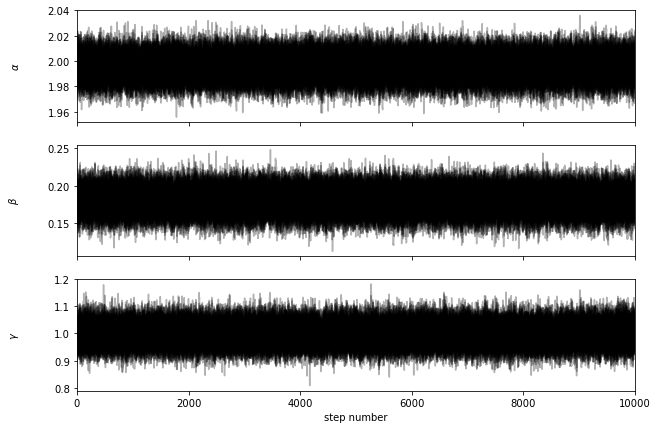

In [17]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

labels = [r"$\alpha$", r"$\beta$", r"$\gamma$"]
for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

As mentioned above, the walkers start in small distributions around the
maximum likelihood values and then they quickly wander and start exploring the
full posterior distribution.
In fact, after fewer than 50 steps, the samples seem pretty well "burnt-in".
That is a hard statement to make quantitatively, but we can look at an estimate
of the integrated autocorrelation time (see the :ref:`autocorr` tutorial for more details):

In [18]:
tau = sampler.get_autocorr_time()
print(tau)

[36.31517749 36.93574453 37.07683011]


This suggests that only about 40 steps are needed for the chain to "forget" where it started.
It's not unreasonable to throw away a few times this number of steps as "burn-in".
Let's discard the initial 100 steps, thin by about half the autocorrelation time (15 steps), and flatten the chain so that we have a flat list of samples:

In [19]:
flat_samples = sampler.get_chain(discard=100, thin=40, flat=True)
print(flat_samples.shape)

(15808, 3)


In [20]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.647


## Results

Now that we have this list of samples, let's make one of the most useful plots
you can make with your MCMC results: *a corner plot*.
You'll need the [corner.py module](http://corner.readthedocs.io) but
once you have it, generating a corner plot is as simple as:

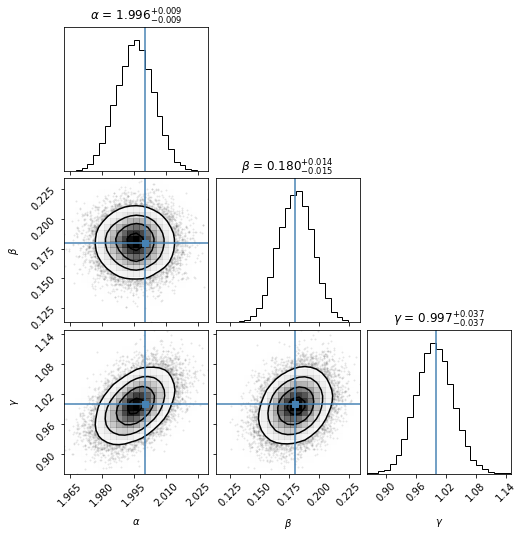

In [21]:
import corner

alpha_true = 2.
beta_true = 0.18
gamma_true = 1.

fig = corner.corner(
    flat_samples, bins=25, labels=labels, smooth=True, \
    truths=[alpha_true,beta_true,gamma_true],\
    show_titles=True,title_fmt=".3f");

In [22]:
g = flat_samples[:, 2]

def gaussian(x, mean, amplitude, s0):
    return amplitude * np.exp( - (x - mean)**2 / 2 /s0**2)

gamma: 0.9970437097850395 \pm 0.00014836412110294674
sigma: -0.037305021386255084 \pm 0.00014836713624215484


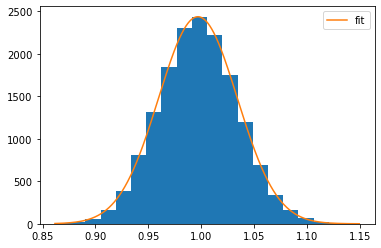

In [23]:
bin_heights, bin_borders, _ = plt.hist(g, bins=20)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, pcov = curve_fit(gaussian, bin_centers, bin_heights, p0=[1., 0., 1.])

perr = np.sqrt(np.diag(pcov))
print('gamma:',popt[0],'\pm',perr[0])
print('sigma:',popt[2],'\pm',perr[2])

x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='fit')
plt.legend()
plt.show()

In [24]:
from IPython.display import display, Math


labels_2 = [r"\alpha", r"\beta", r"\gamma"]
for i in range(n_dim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels_2[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [25]:
print("Maximum likelihood estimates:")
print("alpha = {0:.3f}".format(alpha_ml2))
print("beta = {0:.3f}".format(beta_ml2))
print("gamma = {0:.3f}".format(gamma_ml2))
#print("delta = {0:.3f}".format(delta_ml))

Maximum likelihood estimates:
alpha = 1.996
beta = 0.180
gamma = 0.995


# Parallel

In [26]:
from multiprocessing import Pool

In [27]:
with Pool(processes=10) as pool:
    sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_probability, args=(z_S, z_L, velDisp, velDispErr, theta_E, \
                                                                             seeing_atm, theta_ap, delta, alpha_0, \
                                                                             eps_alpha_0, beta_0, eps_beta_0,), pool=pool)
    solu = np.asarray([2.0, 0.18, 1.0])
    p0 = soln.x + 1e-5 * np.random.randn(n_walkers, n_dim)

    # Run n_burn steps as a burn-in:
    print('Running burn-in ...')
    pos, prob, state = sampler.run_mcmc(p0, n_burn, progress=True);

    # Reset the chain to remove the burn-in samples:
    sampler.reset();

    # Starting from the final position in the burn-in chain, sample for n_steps steps:
    print('Sampling ...')
    sampler.run_mcmc(pos, n_steps, rstate0=state, progress=True);

Running burn-in ...


100%|████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 46.32it/s]


Sampling ...


100%|██████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:28<00:00, 47.92it/s]
